In [237]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt


In [238]:
df = pd.read_csv('../Data/all-data.csv', encoding='latin-1', names=['sentiment', 'text'])
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [239]:
# df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'] = df['sentiment'].map({'positive': 2, 'negative': 0, 'neutral': 1})
df.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [240]:
sentiment = df.iloc[:,0]
headline = df.iloc[:,1]

sentiment.value_counts()

sentiment
1    2879
2    1363
0     604
Name: count, dtype: int64

In [241]:
num_classes = df['sentiment'].nunique()
print("Class count:", num_classes)
total_samples = len(df)

class_weights = []
for i in range(num_classes):
    class_weights.append(total_samples/(num_classes*np.sum(sentiment==i)))
class_weights = np.array(class_weights)
print("Class weights:", class_weights)


Class count: 3
Class weights: [2.67439294 0.56107445 1.18513084]


In [242]:
import torch
import torchtext
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

torchtext.disable_torchtext_deprecation_warning()

In [243]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [244]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, headline), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
# print(vocab.get_stoi())

In [245]:
vocab_size = len(vocab)
vocab_size

10631

In [246]:
class HeadlineDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(text)
        indices = [self.vocab[token] for token in tokens]
        x_tensor = torch.tensor(indices, dtype=torch.long)
        y_tensor = torch.tensor(self.labels[idx], dtype=torch.float)
        return x_tensor, y_tensor

In [247]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=vocab['<unk>'])
    labels_tensor = torch.stack(labels)
    return texts_padded, labels_tensor

In [248]:
X = headline
y = sentiment
dataset = HeadlineDataset(X, y, vocab, tokenizer)

train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [249]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


In [250]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha[target] * (1-pt)**self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [251]:

embedding_dim = 128
hidden_dim = 256
num_layers = 2
num_classes = 3

model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, num_classes).to(device)
model(train_dataset[0][0].unsqueeze(0).to(device))

tensor([[-0.0044,  0.0108, -0.1262]], grad_fn=<AddmmBackward0>)

In [252]:
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=torch.tensor(class_weights).to(device), gamma=2, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)


In [253]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return train_loss, train_acc

def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_preds = []

    with torch.inference_mode():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y.long())

            running_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            y_true += y.tolist()
            y_preds += predicted.tolist()
            
    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    test_precision = precision_score(y_true, y_preds, average='macro', zero_division=0)
    test_recall = recall_score(y_true, y_preds, average='macro', zero_division=0)
    test_f1 = f1_score(y_true, y_preds, average='macro', zero_division=0)
    
    return test_loss, test_acc, test_precision, test_recall, test_f1

    
            

In [254]:
from tqdm.auto import tqdm


num_epochs = 10
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_precisions = []
test_recalls = []
test_f1s = []

for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}, Time: {time.time()-start_time:.4f}s')
    

 10%|█         | 1/10 [00:27<04:08, 27.56s/it]

Epoch: 1/10, Train Loss: 66.6217, Train Acc: 0.2882, Test Loss: 57.9795, Test Acc: 0.1252, Test Precision: 0.1335, Test Recall: 0.2982, Test F1: 0.1202, Time: 27.5554s


 20%|██        | 2/10 [00:53<03:34, 26.78s/it]

Epoch: 2/10, Train Loss: 61.3471, Train Acc: 0.3052, Test Loss: 56.9562, Test Acc: 0.4072, Test Precision: 0.5999, Test Recall: 0.3956, Test F1: 0.2983, Time: 26.2297s


 30%|███       | 3/10 [01:21<03:09, 27.12s/it]

Epoch: 3/10, Train Loss: 55.5046, Train Acc: 0.5322, Test Loss: 52.1651, Test Acc: 0.5557, Test Precision: 0.4951, Test Recall: 0.4452, Test F1: 0.4168, Time: 27.5266s


 40%|████      | 4/10 [01:48<02:43, 27.19s/it]

Epoch: 4/10, Train Loss: 44.4362, Train Acc: 0.6480, Test Loss: 51.7450, Test Acc: 0.5777, Test Precision: 0.4909, Test Recall: 0.4535, Test F1: 0.4323, Time: 27.2932s


 50%|█████     | 5/10 [02:16<02:17, 27.42s/it]

Epoch: 5/10, Train Loss: 30.4179, Train Acc: 0.7458, Test Loss: 51.4813, Test Acc: 0.6369, Test Precision: 0.5536, Test Recall: 0.5900, Test F1: 0.5491, Time: 27.8297s


 60%|██████    | 6/10 [02:44<01:50, 27.72s/it]

Epoch: 6/10, Train Loss: 18.7176, Train Acc: 0.8531, Test Loss: 71.6737, Test Acc: 0.6699, Test Precision: 0.5842, Test Recall: 0.5780, Test F1: 0.5804, Time: 28.2857s


 70%|███████   | 7/10 [03:13<01:23, 27.99s/it]

Epoch: 7/10, Train Loss: 7.9728, Train Acc: 0.9376, Test Loss: 80.0442, Test Acc: 0.6424, Test Precision: 0.5690, Test Recall: 0.6091, Test F1: 0.5828, Time: 28.5584s


 80%|████████  | 8/10 [03:40<00:55, 27.69s/it]

Epoch: 8/10, Train Loss: 3.3779, Train Acc: 0.9723, Test Loss: 102.0097, Test Acc: 0.6644, Test Precision: 0.6035, Test Recall: 0.6100, Test F1: 0.6050, Time: 27.0439s


 90%|█████████ | 9/10 [04:08<00:27, 27.74s/it]

Epoch: 9/10, Train Loss: 2.3558, Train Acc: 0.9825, Test Loss: 119.9446, Test Acc: 0.6685, Test Precision: 0.6292, Test Recall: 0.6037, Test F1: 0.6088, Time: 27.8552s


100%|██████████| 10/10 [04:37<00:00, 27.72s/it]

Epoch: 10/10, Train Loss: 1.1975, Train Acc: 0.9900, Test Loss: 121.9400, Test Acc: 0.6850, Test Precision: 0.6184, Test Recall: 0.6185, Test F1: 0.6184, Time: 28.9811s


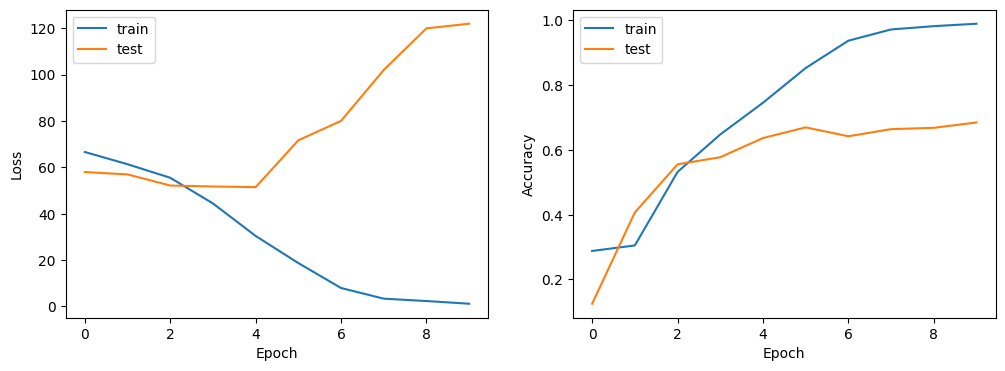

In [260]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

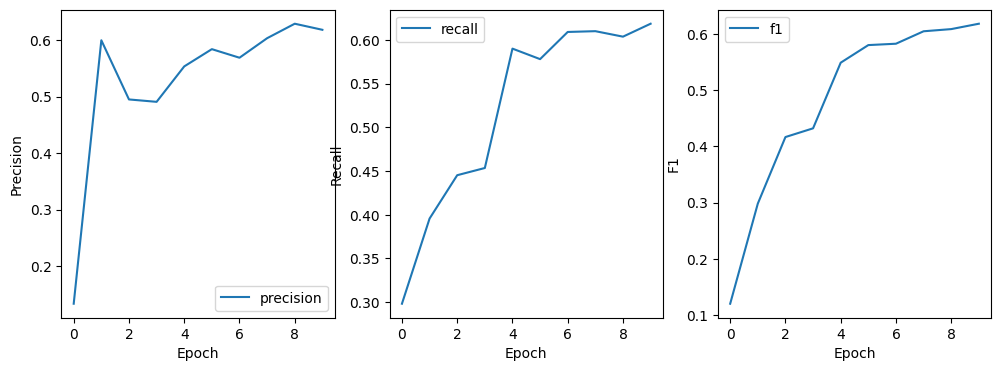

In [256]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(test_precisions, label='precision')
plt.xlabel('Epoch')
plt.ylabel('Precision') 
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_recalls, label='recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_f1s, label='f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.show()

              precision    recall  f1-score   support

         0.0       0.52      0.53      0.53        85
         1.0       0.77      0.78      0.77       442
         2.0       0.56      0.55      0.56       200

    accuracy                           0.69       727
   macro avg       0.62      0.62      0.62       727
weighted avg       0.68      0.69      0.68       727



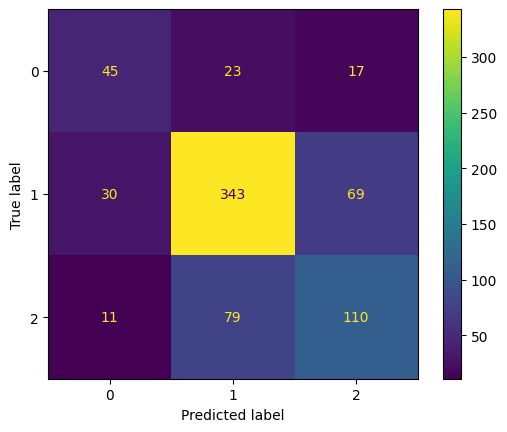

In [257]:
model.eval()
y_true = []
y_preds = []

with torch.inference_mode():
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        y_true += y.tolist()
        y_preds += predicted.tolist()
    
print(classification_report(y_true, y_preds))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_preds)).plot()

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       519
         1.0       1.00      1.00      1.00      2437
         2.0       1.00      0.97      0.99      1163

    accuracy                           0.99      4119
   macro avg       0.98      0.99      0.98      4119
weighted avg       0.99      0.99      0.99      4119



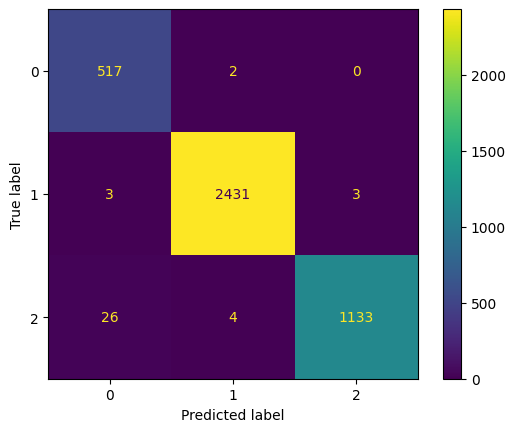

In [258]:
model.eval()
y_true = []
y_preds = []

with torch.inference_mode():
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        y_true += y.tolist()
        y_preds += predicted.tolist()
        
print(classification_report(y_true, y_preds))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_preds)).plot()


In [259]:
torch.save(model.state_dict(), 'sentiment.pth')